In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
from collections import Counter
import cv2
from sklearn.model_selection import train_test_split

In [2]:
# Path to the data directory
data_dir = Path("dataset/")

# Get list of all the images
images = list(data_dir.glob("*.png"))

num_images = len(images)

print("Number of images: ", num_images)

Number of images:  14


Shape of images:  (50, 150, 4)


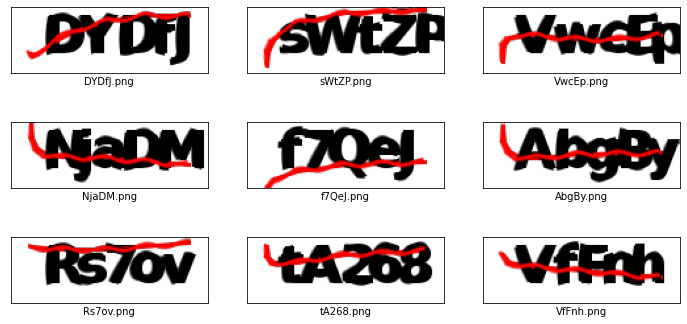

In [3]:
plt.figure(figsize=(12,6))
random_images = random.sample(range(num_images), 9)
print("Shape of images: ", mpimg.imread(str(images[random_images[0]]),0).shape)

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(mpimg.imread(str(images[random_images[i]]),0))
    plt.xlabel(str(images[random_images[i]]).split('\\')[-1].split('/')[-1])
plt.show()

In [4]:
characters = set()
for img_path in images:
    label = img_path.name.split(".png")[0]
    for ch in label:
        characters.add(ch)

print("Number of unqiue charcaters: ", len(characters))
print("Characters present: ", sorted(characters))
print("Total number of samples: ", len(images))

Number of unqiue charcaters:  43
Characters present:  ['2', '3', '5', '6', '7', '8', 'A', 'B', 'C', 'D', 'E', 'F', 'J', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'Z', 'a', 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'k', 'n', 'o', 'p', 'q', 'r', 's', 't', 'v', 'w', 'y']
Total number of samples:  14
